In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# Entendendo os fatores que levam a um melhor desempenho na classificação geral (cg)

In [2]:
# Load the dataset
data = pd.read_csv(
    "../data/df_pooled_ranking_clean.csv"
)  # Replace with your dataset path

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   nome                  1646 non-null   object 
 1   ano                   1646 non-null   int64  
 2   anos_pm               1646 non-null   float64
 3   bolsista_encoded      1646 non-null   int64  
 4   cg                    1646 non-null   float64
 5   diff_fase             1646 non-null   float64
 6   iaa                   1646 non-null   float64
 7   ian                   1646 non-null   float64
 8   ida                   1646 non-null   float64
 9   idade                 1646 non-null   float64
 10  ieg                   1646 non-null   float64
 11  inde                  1646 non-null   float64
 12  ipp                   1646 non-null   float64
 13  ips                   1646 non-null   float64
 14  ipv                   1646 non-null   float64
 15  na_fase              

In [3]:
data.set_index("nome", inplace=True)

data["ano"] = data["ano"].astype(int)

data["bolsista_encoded"] = data["bolsista_encoded"].astype(int)

data["cg"] = data["cg"].astype(int)

data["ian"] = data["ian"].astype("category")

data["na_fase"] = data["na_fase"].astype(int)

data["ponto_virada_encoded"] = data["ponto_virada_encoded"].astype(int)

data["sexo_encoded"] = data["sexo_encoded"].astype(int)

data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1646 entries, ALUNO-2 to ALUNO-1349
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ano                   1646 non-null   int64   
 1   anos_pm               1646 non-null   float64 
 2   bolsista_encoded      1646 non-null   int64   
 3   cg                    1646 non-null   int64   
 4   diff_fase             1646 non-null   float64 
 5   iaa                   1646 non-null   float64 
 6   ian                   1646 non-null   category
 7   ida                   1646 non-null   float64 
 8   idade                 1646 non-null   float64 
 9   ieg                   1646 non-null   float64 
 10  inde                  1646 non-null   float64 
 11  ipp                   1646 non-null   float64 
 12  ips                   1646 non-null   float64 
 13  ipv                   1646 non-null   float64 
 14  na_fase               1646 non-null   int64   
 1

In [4]:
data.loc[data["ano"] != 2022, "cg"] = np.nan


## Considerando que não temos o ranking dos anos anteriores, qual a variável definitiva para a sua definição?

In [5]:
df = data.copy()
df = df.dropna(subset=["cg"])
df.head()


,ano,anos_pm,bolsista_encoded,cg,diff_fase,iaa,ian,ida,idade,ieg,inde,ipp,ips,ipv,na_fase,ponto_virada_encoded,sexo_encoded
nome,,,,,,,,,,,,,,,,,
ALUNO-2,2022,0.0,0,245.0,-2.0,10.00002,5.0,8.816667,11.0,7.581705,7.675509,5.625000,7.5,7.916665,0,0,1
ALUNO-4,2022,0.0,0,451.0,-1.0,10.00002,5.0,5.083333,12.0,8.071429,7.117065,6.250000,7.5,8.055553,0,0,0
ALUNO-5,2022,3.0,0,415.0,-1.0,6.41668,5.0,7.083333,12.0,8.557505,7.232336,6.458333,7.5,7.833337,0,0,0
ALUNO-6,2022,0.0,0,221.0,0.0,9.00002,10.0,5.500000,11.0,9.333333,7.741669,6.250000,7.5,7.500000,1,0,1
ALUNO-7,2022,0.0,0,357.0,-1.0,10.00002,5.0,5.583333,11.0,9.314954,7.406743,5.937500,7.5,7.916670,0,0,0


In [6]:
# # Step 1: Feature Selection using Random Forest
# features_for_importance = df.drop(columns=["cg"])
# target_for_importance = df["cg"]

# # Standardize the features
# scaler = StandardScaler()
# features_scaled_for_importance = scaler.fit_transform(features_for_importance)

# # Train a Random Forest to get feature importance
# rf = RandomForestRegressor(random_state=42)
# rf.fit(features_scaled_for_importance, target_for_importance)

# # Get feature importances and sort them
# importances = rf.feature_importances_
# feature_names = features_for_importance.columns
# sorted_indices = np.argsort(importances)[::-1]

# # Print the most important features
# print("Feature ranking:")
# for i in sorted_indices:
#     print(f"{feature_names[i]}: {importances[i]}")


def features_eval(df, target_feature):
    # Step 1: Feature Selection using Random Forest
    features_for_importance = df.drop(columns=[target_feature])
    target_for_importance = df[target_feature]

    # Standardize the features
    scaler = StandardScaler()
    features_scaled_for_importance = scaler.fit_transform(features_for_importance)

    # Train a Random Forest to get feature importance
    rf = RandomForestRegressor(random_state=42)
    rf.fit(features_scaled_for_importance, target_for_importance)

    # Get feature importances and sort them
    importances = rf.feature_importances_
    feature_names = features_for_importance.columns
    sorted_indices = np.argsort(importances)[::-1]

    # Print the most important features
    print("Feature ranking:")
    for i in sorted_indices:
        print(f"{feature_names[i]}: {importances[i]}")
    return feature_names[sorted_indices]


features_eval(df, "cg")


Feature ranking:
inde: 0.9999604207034338
ida: 6.450235229912001e-06
ipv: 5.703408232569696e-06
ieg: 5.619562093275832e-06
ipp: 4.317378117407441e-06
iaa: 4.120746252544992e-06
idade: 3.0283669639519128e-06
anos_pm: 2.8432248829636834e-06
ips: 2.345538977785719e-06
diff_fase: 1.7250871353563491e-06
sexo_encoded: 1.4122128040479032e-06
ian: 6.857451858915493e-07
na_fase: 6.482690465724951e-07
ponto_virada_encoded: 3.574124260538529e-07
bolsista_encoded: 3.2210921768804024e-07
ano: 0.0


Index(['inde', 'ida', 'ipv', 'ieg', 'ipp', 'iaa', 'idade', 'anos_pm', 'ips',
       'diff_fase', 'sexo_encoded', 'ian', 'na_fase', 'ponto_virada_encoded',
       'bolsista_encoded', 'ano'],
      dtype='object')

A variável que dita a classificação geral é o `inde`. Então vamos definir a classificação para os anos anteriores:

In [7]:
def set_cg(df):
    df = df.sort_values(by="inde", ascending=False)
    df.reset_index(inplace=True)
    df["cg"] = pd.Series(range(1, len(df) + 1))
    df.set_index("nome", inplace=True)

    return df


cg_2021 = set_cg(data[data["ano"] == 2021][["inde", "cg"]])
cg_2022 = set_cg(data[data["ano"] == 2022][["inde", "cg"]])

# fill cg values in the original dataframe with the new cg values for the corresponding year
data.loc[cg_2021.index, "cg"] = cg_2021["cg"]
data.loc[cg_2022.index, "cg"] = cg_2022["cg"]

data.sort_values(by="cg", ascending=True).head()


,ano,anos_pm,bolsista_encoded,cg,diff_fase,iaa,ian,ida,idade,ieg,inde,ipp,ips,ipv,na_fase,ponto_virada_encoded,sexo_encoded
nome,,,,,,,,,,,,,,,,,
ALUNO-75,2020,1.0,1,1.0,1.0,10.00002,10.0,9.000000,11.0,10.000000,9.687504,9.37500,10.000,9.750010,0,1,1
ALUNO-75,2021,2.0,1,1.0,1.0,10.00000,10.0,8.500000,12.0,9.200000,9.108000,8.80000,7.500,9.700000,0,1,1
ALUNO-75,2022,3.0,1,1.0,2.0,10.00002,10.0,8.500000,13.0,9.660714,9.441522,9.21875,9.375,9.750010,0,1,1
ALUNO-916,2022,5.0,1,2.0,0.0,8.75001,10.0,8.511111,15.0,10.000000,9.354308,9.06250,9.375,9.666675,1,1,1
ALUNO-916,2021,4.0,1,2.0,0.0,8.30000,10.0,7.800000,14.0,9.700000,8.866000,9.20000,7.500,9.300000,1,1,1


Escreve em arquivo o resultado da definição do cg:

In [8]:
data.to_csv("../data/df_pooled_ranking_clean_with_cg.csv")


## Faz sentido realizar a análise considerando a variação do `cg` no tempo?

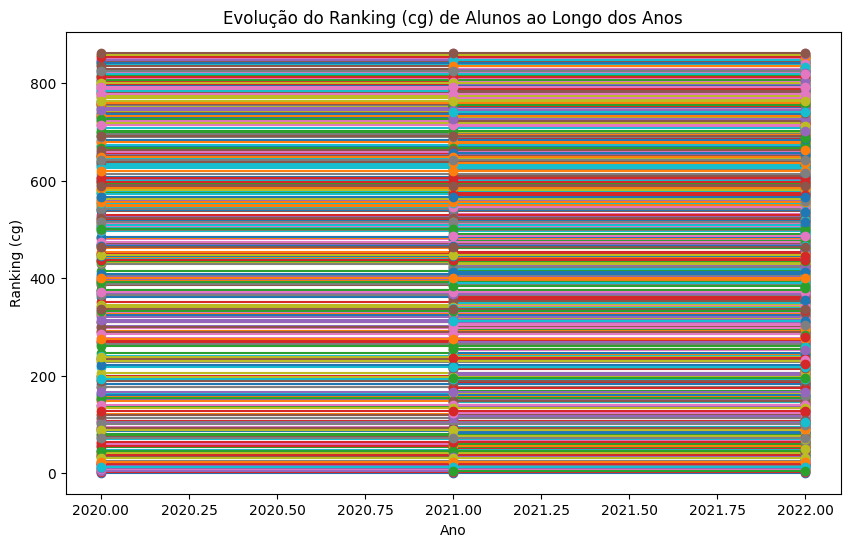

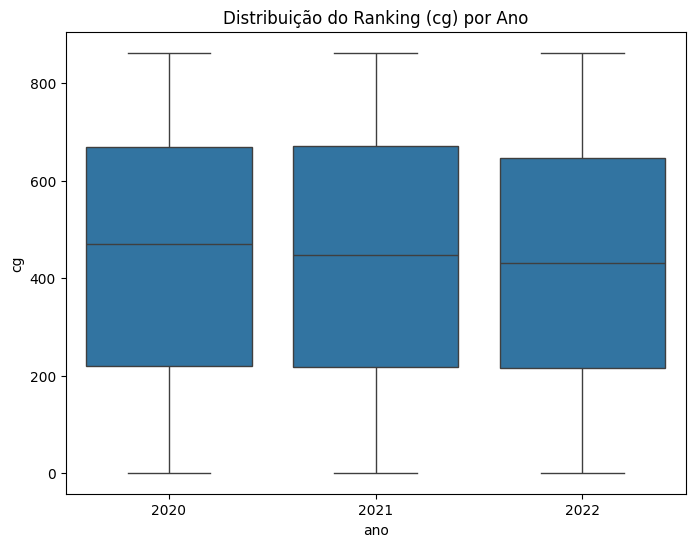

             mean  std
aluno_id              
ALUNO-100   720.0  0.0
ALUNO-1000  592.0  NaN
ALUNO-1001  367.0  0.0
ALUNO-1002  289.0  0.0
ALUNO-1004   88.0  0.0
...           ...  ...
ALUNO-994   340.0  0.0
ALUNO-995   419.0  0.0
ALUNO-996   465.0  0.0
ALUNO-997   151.0  0.0
ALUNO-998   220.0  NaN

[862 rows x 2 columns]
Resultado do teste ANOVA: F_onewayResult(statistic=0.5861200781897649, pvalue=0.5565985213615023)


In [9]:
# Carregar os dados
df = data.copy().reset_index().rename({"nome": "aluno_id"}, axis=1)


# 1. Agrupar os dados por aluno e ano, selecionando as colunas relevantes
# Suponho que exista uma coluna 'aluno_id' que identifica cada aluno e 'ano' para o ano específico
# Adapte o nome da coluna 'aluno_id' caso necessário
df_sorted = df.sort_values(by=["aluno_id", "ano"])

# 2. Calcular a diferença do ranking cg entre os anos para cada aluno
df["cg_diff_2021_2020"] = df.groupby("aluno_id")["cg"].diff(periods=1)
df["cg_diff_2022_2021"] = df.groupby("aluno_id")["cg"].diff(periods=2)

# 3. Visualizar a evolução do ranking de cada aluno ao longo do tempo com um gráfico de linhas
plt.figure(figsize=(10, 6))
for aluno in df["aluno_id"].unique():
    aluno_data = df[df["aluno_id"] == aluno]
    plt.plot(aluno_data["ano"], aluno_data["cg"], marker="o", label=f"Aluno {aluno}")

plt.title("Evolução do Ranking (cg) de Alunos ao Longo dos Anos")
plt.xlabel("Ano")
plt.ylabel("Ranking (cg)")
# plt.legend(loc="best", bbox_to_anchor=(1, 0.5))
plt.show()

# 4. Criar boxplots para comparar a distribuição de cg em cada ano
plt.figure(figsize=(8, 6))
sns.boxplot(x="ano", y="cg", data=df, legend=False)
plt.title("Distribuição do Ranking (cg) por Ano")
plt.show()

# 5. Analisar a variação do ranking de cada aluno
df_variation = df.groupby("aluno_id")["cg"].agg(["mean", "std"])
print(df_variation)

# Opcional: realizar um teste ANOVA para verificar se a variação de cg entre os anos é significativa
from scipy.stats import f_oneway

# Criar listas com os valores de cg por ano
cg_2020 = df[df["ano"] == 2020]["cg"]
cg_2021 = df[df["ano"] == 2021]["cg"]
cg_2022 = df[df["ano"] == 2022]["cg"]

# Teste ANOVA para ver se há diferença significativa nos rankings entre os anos
anova_result = f_oneway(cg_2020, cg_2021, cg_2022)
print("Resultado do teste ANOVA:", anova_result)


### Resultado da ANOVA quanto à variação temporal da classificação no tempo:

O p-value de 0.556 é maior que o nível de significância usual de 0.05 (ou 5%). Isso significa que não há evidências suficientes para rejeitar a hipótese nula.

Hipótese nula (H₀): O ranking (cg) dos alunos não varia significativamente entre os anos.
Hipótese alternativa (H₁): O ranking (cg) dos alunos varia significativamente entre os anos.
Dado que o p-value é alto, não podemos concluir que existe uma diferença significativa entre os rankings nos diferentes anos. Em outras palavras, o teste ANOVA sugere que a variação dos rankings entre os anos de 2020, 2021 e 2022 não é estatisticamente significativa.

Logo, uma abordagem razoável é utilizar a média dos indicadores e nos outros casos somente os dados de 2022.

In [10]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1646 entries, ALUNO-2 to ALUNO-1349
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ano                   1646 non-null   int64   
 1   anos_pm               1646 non-null   float64 
 2   bolsista_encoded      1646 non-null   int64   
 3   cg                    1646 non-null   float64 
 4   diff_fase             1646 non-null   float64 
 5   iaa                   1646 non-null   float64 
 6   ian                   1646 non-null   category
 7   ida                   1646 non-null   float64 
 8   idade                 1646 non-null   float64 
 9   ieg                   1646 non-null   float64 
 10  inde                  1646 non-null   float64 
 11  ipp                   1646 non-null   float64 
 12  ips                   1646 non-null   float64 
 13  ipv                   1646 non-null   float64 
 14  na_fase               1646 non-null   int64   
 1

In [11]:
df = data.reset_index().copy()
df = df[df["ano"] == 2022]
df = df.drop(columns=["ano"], axis=1)
df.set_index("nome", inplace=True)
df.head()


,anos_pm,bolsista_encoded,cg,diff_fase,iaa,ian,ida,idade,ieg,inde,ipp,ips,ipv,na_fase,ponto_virada_encoded,sexo_encoded
nome,,,,,,,,,,,,,,,,
ALUNO-2,0.0,0,245.0,-2.0,10.00002,5.0,8.816667,11.0,7.581705,7.675509,5.625000,7.5,7.916665,0,0,1
ALUNO-4,0.0,0,451.0,-1.0,10.00002,5.0,5.083333,12.0,8.071429,7.117065,6.250000,7.5,8.055553,0,0,0
ALUNO-5,3.0,0,415.0,-1.0,6.41668,5.0,7.083333,12.0,8.557505,7.232336,6.458333,7.5,7.833337,0,0,0
ALUNO-6,0.0,0,221.0,0.0,9.00002,10.0,5.500000,11.0,9.333333,7.741669,6.250000,7.5,7.500000,1,0,1
ALUNO-7,0.0,0,357.0,-1.0,10.00002,5.0,5.583333,11.0,9.314954,7.406743,5.937500,7.5,7.916670,0,0,0


## Teste com os dados de 2022, uma vez que não há diferença substancial ao longo dos anos para a definição do `cg`

In [12]:
df_2022 = pd.read_csv("../data/df_2022_preproc_select.csv")

df_2022.head()


,nome,idade,fase,turma,ano_ingresso,bolsista,inde,cg,cf,ct,...,destaque_ipv_resultado_encoded,rec_ava_1_resultado,rec_ava_2_resultado,rec_ava_3_resultado,rec_ava_4_resultado,rec_ava_1_resultado_encoded,rec_ava_2_resultado_encoded,rec_ava_3_resultado_encoded,rec_ava_4_resultado_encoded,rec_sintese
0,ALUNO-2,11.0,0,K,2022.0,Não,7.675509,245.0,66.0,6.0,...,1,Positivo,Neutro,NaN,NaN,1.0,0.0,NaN,NaN,1.0
1,ALUNO-4,12.0,2,J,2022.0,Não,7.117065,451.0,69.0,3.0,...,1,Positivo,Neutro,Positivo,NaN,1.0,0.0,1.0,NaN,1.0
2,ALUNO-5,12.0,2,L,2019.0,Não,7.232336,415.0,61.0,12.0,...,1,Neutro,Positivo,Neutro,NaN,0.0,1.0,0.0,NaN,0.0
3,ALUNO-6,11.0,2,K,2022.0,Não,7.741669,221.0,35.0,2.0,...,1,Neutro,Positivo,Neutro,NaN,0.0,1.0,0.0,NaN,0.0
4,ALUNO-7,11.0,1,U,2022.0,Não,7.406743,357.0,93.0,7.0,...,1,Positivo,Positivo,NaN,NaN,1.0,1.0,NaN,NaN,1.0


In [13]:
df_2022.columns.to_list()


['nome',
 'idade',
 'fase',
 'turma',
 'ano_ingresso',
 'bolsista',
 'inde',
 'cg',
 'cf',
 'ct',
 'iaa',
 'ieg',
 'ips',
 'ida',
 'nota_port',
 'nota_mat',
 'nota_ing',
 'qtd_aval',
 'ipp',
 'indicado_bolsa',
 'ipv',
 'ian',
 'nivel_ideal',
 'sexo',
 'corraca',
 'bolsista_encoded',
 'ponto_virada_encoded',
 'pedra',
 'pedra_encoded',
 'anos_pm',
 'fase_ideal',
 'destaque_ieg_resultado',
 'destaque_ida_resultado',
 'destaque_ipv_resultado',
 'destaque_ieg_resultado_encoded',
 'destaque_ida_resultado_encoded',
 'destaque_ipv_resultado_encoded',
 'rec_ava_1_resultado',
 'rec_ava_2_resultado',
 'rec_ava_3_resultado',
 'rec_ava_4_resultado',
 'rec_ava_1_resultado_encoded',
 'rec_ava_2_resultado_encoded',
 'rec_ava_3_resultado_encoded',
 'rec_ava_4_resultado_encoded',
 'rec_sintese']

In [14]:
df_2022 = df_2022[
    [
        "nome",
        "idade",
        "cg",
        "pedra",
        "inde",
        "iaa",
        "ieg",
        "ips",
        "ida",
        "ipv",
        "ian",
        "ipp",
        "qtd_aval",
        "indicado_bolsa",
        "sexo",
        "ponto_virada_encoded",
        "fase",
        "anos_pm",
        "fase_ideal",
        "destaque_ieg_resultado_encoded",
        "destaque_ida_resultado_encoded",
        "destaque_ipv_resultado_encoded",
        "rec_sintese",
    ]
].copy()


df_2022.head()


,nome,idade,cg,pedra,inde,iaa,ieg,ips,ida,ipv,...,indicado_bolsa,sexo,ponto_virada_encoded,fase,anos_pm,fase_ideal,destaque_ieg_resultado_encoded,destaque_ida_resultado_encoded,destaque_ipv_resultado_encoded,rec_sintese
0,ALUNO-2,11.0,245.0,Ametista,7.675509,10.00002,7.581705,7.5,8.816667,7.916665,...,Sim,F,0,0,0.0,2.0,1,1,1,1.0
1,ALUNO-4,12.0,451.0,Ametista,7.117065,10.00002,8.071429,7.5,5.083333,8.055553,...,Não,M,0,2,0.0,3.0,1,-1,1,1.0
2,ALUNO-5,12.0,415.0,Ametista,7.232336,6.41668,8.557505,7.5,7.083333,7.833337,...,Não,M,0,2,3.0,3.0,1,-1,1,0.0
3,ALUNO-6,11.0,221.0,Ametista,7.741669,9.00002,9.333333,7.5,5.500000,7.500000,...,Não,F,0,2,0.0,2.0,1,-1,1,0.0
4,ALUNO-7,11.0,357.0,Ametista,7.406743,10.00002,9.314954,7.5,5.583333,7.916670,...,Não,M,0,1,0.0,2.0,1,-1,1,1.0


In [15]:
df_2022["diff_fase"] = df_2022["fase"] - df_2022["fase_ideal"]
df_2022.drop(columns=["fase_ideal", "fase"], inplace=True)
df_2022.head()


,nome,idade,cg,pedra,inde,iaa,ieg,ips,ida,ipv,...,qtd_aval,indicado_bolsa,sexo,ponto_virada_encoded,anos_pm,destaque_ieg_resultado_encoded,destaque_ida_resultado_encoded,destaque_ipv_resultado_encoded,rec_sintese,diff_fase
0,ALUNO-2,11.0,245.0,Ametista,7.675509,10.00002,7.581705,7.5,8.816667,7.916665,...,2.0,Sim,F,0,0.0,1,1,1,1.0,-2.0
1,ALUNO-4,12.0,451.0,Ametista,7.117065,10.00002,8.071429,7.5,5.083333,8.055553,...,3.0,Não,M,0,0.0,1,-1,1,1.0,-1.0
2,ALUNO-5,12.0,415.0,Ametista,7.232336,6.41668,8.557505,7.5,7.083333,7.833337,...,3.0,Não,M,0,3.0,1,-1,1,0.0,-1.0
3,ALUNO-6,11.0,221.0,Ametista,7.741669,9.00002,9.333333,7.5,5.500000,7.500000,...,3.0,Não,F,0,0.0,1,-1,1,0.0,0.0
4,ALUNO-7,11.0,357.0,Ametista,7.406743,10.00002,9.314954,7.5,5.583333,7.916670,...,2.0,Não,M,0,0.0,1,-1,1,1.0,-1.0


In [16]:
df_2022.to_csv("../data/df_2022_clustering.csv")


### Adequação de `cg` para o algoritmo - normalização e inversão (quanto menor, melhor)

In [17]:
df = pd.read_csv("../data/df_2022_clustering.csv")

# Definir o valor mínimo e máximo da coluna "cg"
min_cg = df["cg"].min()
max_cg = df["cg"].max()

# Aplicar a normalização inversa para refletir a ordem de melhor ranking
df["cg_normalized_inverted"] = 1 - (df["cg"] - min_cg) / (max_cg - min_cg)

# Exibir as primeiras linhas da normalização invertida
df_sorted_inverted = df[["cg", "cg_normalized_inverted"]].sort_values(by="cg").head()
print(df_sorted_inverted)


      cg  cg_normalized_inverted
50   1.0                1.000000
583  2.0                0.998839
104  3.0                0.997677
852  4.0                0.996516
594  5.0                0.995354


### Random Forest para análise de fatores que contribuem para melhor cg

In [18]:
df.drop(columns=["Unnamed: 0"], inplace=True)
df.isna().sum()


nome                              0
idade                             0
cg                                0
pedra                             0
inde                              0
iaa                               0
ieg                               0
ips                               0
ida                               0
ipv                               0
ian                               0
ipp                               0
qtd_aval                          0
indicado_bolsa                    0
sexo                              1
ponto_virada_encoded              0
anos_pm                           0
destaque_ieg_resultado_encoded    0
destaque_ida_resultado_encoded    0
destaque_ipv_resultado_encoded    0
rec_sintese                       2
diff_fase                         0
cg_normalized_inverted            0
dtype: int64

In [19]:
corr_matrix = df.drop(
    columns=["nome", "pedra", "sexo", "indicado_bolsa"], axis=1
).corr()

corr_matrix.style.background_gradient(cmap="coolwarm")


,idade,cg,inde,iaa,ieg,ips,ida,ipv,ian,ipp,qtd_aval,ponto_virada_encoded,anos_pm,destaque_ieg_resultado_encoded,destaque_ida_resultado_encoded,destaque_ipv_resultado_encoded,rec_sintese,diff_fase,cg_normalized_inverted
idade,1.000000,0.359791,-0.360518,-0.264404,-0.320758,-0.104236,-0.318002,-0.210611,-0.324827,0.488370,0.770615,-0.006744,0.386114,-0.265611,-0.234062,-0.131788,0.228327,-0.363567,-0.359791
cg,0.359791,1.000000,-0.956312,-0.396569,-0.741294,-0.276923,-0.807916,-0.757219,-0.421310,-0.251662,0.178120,-0.474279,0.073761,-0.652172,-0.619161,-0.625367,-0.325611,-0.417172,-1.000000
inde,-0.360518,-0.956312,1.000000,0.463363,0.805282,0.274220,0.820710,0.791634,0.394684,0.285240,-0.196463,0.428505,-0.066108,0.660809,0.551292,0.584382,0.317259,0.402606,0.956312
iaa,-0.264404,-0.396569,0.463363,1.000000,0.330733,0.118804,0.217989,0.263990,0.048871,-0.106104,-0.284307,0.112605,-0.110769,0.259722,0.145692,0.142289,-0.040211,0.032574,0.396569
ieg,-0.320758,-0.741294,0.805282,0.330733,1.000000,0.098460,0.570141,0.595315,0.163949,0.136132,-0.225718,0.266648,-0.103558,0.827673,0.337453,0.438571,0.127216,0.217780,0.741294
ips,-0.104236,-0.276923,0.274220,0.118804,0.098460,1.000000,0.137056,0.211818,0.035888,0.058641,-0.066487,0.149198,-0.251987,0.077672,0.159034,0.158868,0.006076,0.060193,0.276923
ida,-0.318002,-0.807916,0.820710,0.217989,0.570141,0.137056,1.000000,0.622190,0.148094,0.116916,-0.252861,0.337622,-0.048272,0.478871,0.692144,0.492725,0.385585,0.180582,0.807916
ipv,-0.210611,-0.757219,0.791634,0.263990,0.595315,0.211818,0.622190,1.000000,0.113478,0.337496,-0.190860,0.568919,0.016995,0.481471,0.456455,0.726575,0.387259,0.172207,0.757219
ian,-0.324827,-0.421310,0.394684,0.048871,0.163949,0.035888,0.148094,0.113478,1.000000,0.120675,0.026875,0.074775,-0.031090,0.139518,0.084545,0.087452,0.008158,0.838126,0.421310
ipp,0.488370,-0.251662,0.285240,-0.106104,0.136132,0.058641,0.116916,0.337496,0.120675,1.000000,0.687126,0.282521,0.349191,0.078670,0.031813,0.239203,0.423634,0.152042,0.251662


### Análise simplifica de clusterização

In [20]:
def evaluate_features_importance(df, target_col, categorical_features):
    # Definir as variáveis independentes (excluir colunas irrelevantes como 'nome', 'cg', 'cg_normalized_inverted')
    # X = df.drop(columns=["nome", "cg", "cg_normalized_inverted", "inde", "pedra"])
    # y = df["cg_normalized_inverted"]
    X = df.drop(columns=target_col)
    y = df[target_col]

    # Dividir os dados em treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    # Definir pré-processamento para variáveis categóricas (ex: 'pedra' e 'sexo')
    # categorical_features = ["sexo", "indicado_bolsa"]
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    numerical_features = X.drop(columns=categorical_features).columns.tolist()

    numerical_transformer = SimpleImputer(
        strategy="mean"
    )  # Para preencher valores numéricos ausentes
    categorical_transformer = Pipeline(
        steps=[
            (
                "imputer",
                SimpleImputer(strategy="most_frequent"),
            ),  # Preencher categóricos com o valor mais frequente
            (
                "onehot",
                OneHotEncoder(handle_unknown="ignore"),
            ),  # OneHotEncode para variáveis categóricas
        ]
    )

    # Criação do ColumnTransformer para aplicar transformações adequadas a variáveis categóricas e numéricas
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    # Modelo usando RandomForest
    model = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", RandomForestRegressor(random_state=42)),
        ]
    )

    # Dividir os dados em treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_test)

    # Avaliar o modelo
    print("R²:", r2_score(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))

    importances = model.named_steps["regressor"].feature_importances_
    # Extrair nomes das features após a transformação (incluindo categorias expandidas pelo OneHotEncoder)
    feature_names = (
        model.named_steps["preprocessor"]
        .transformers_[1][1]
        .named_steps["onehot"]
        .get_feature_names_out(categorical_features)
    )
    all_features = numerical_features + feature_names.tolist()

    # Criar dataframe de importância
    importance_df = pd.DataFrame(
        {"Feature": all_features, "Importance": importances}
    ).sort_values(by="Importance", ascending=False)
    print(importance_df)
    # Ordenar a importância das variáveis em ordem decrescente
    importance_df = pd.DataFrame(
        {"Feature": all_features, "Importance": importances}
    ).sort_values(by="Importance", ascending=False)

    # Plotar o gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.xlabel("Importância")
    plt.ylabel("Features")
    plt.title("Importância das Features")
    plt.gca().invert_yaxis()  # Inverter o eixo Y para mostrar as features mais importantes no topo
    plt.show()


R²: 0.9065413151650048
MAE: 0.0710430807033091
                           Feature  Importance
4                              ipv    0.403015
2                              ieg    0.318924
11  destaque_ida_resultado_encoded    0.118051
14                       diff_fase    0.040276
5                              ian    0.037759
1                              iaa    0.027587
3                              ips    0.015639
6                              ipp    0.013412
0                            idade    0.009177
9                          anos_pm    0.005360
13                     rec_sintese    0.001860
7                         qtd_aval    0.001541
16                          sexo_M    0.001535
10  destaque_ieg_resultado_encoded    0.001388
8             ponto_virada_encoded    0.001359
15                          sexo_F    0.001087
18              indicado_bolsa_Sim    0.000889
17              indicado_bolsa_Não    0.000626
12  destaque_ipv_resultado_encoded    0.000514


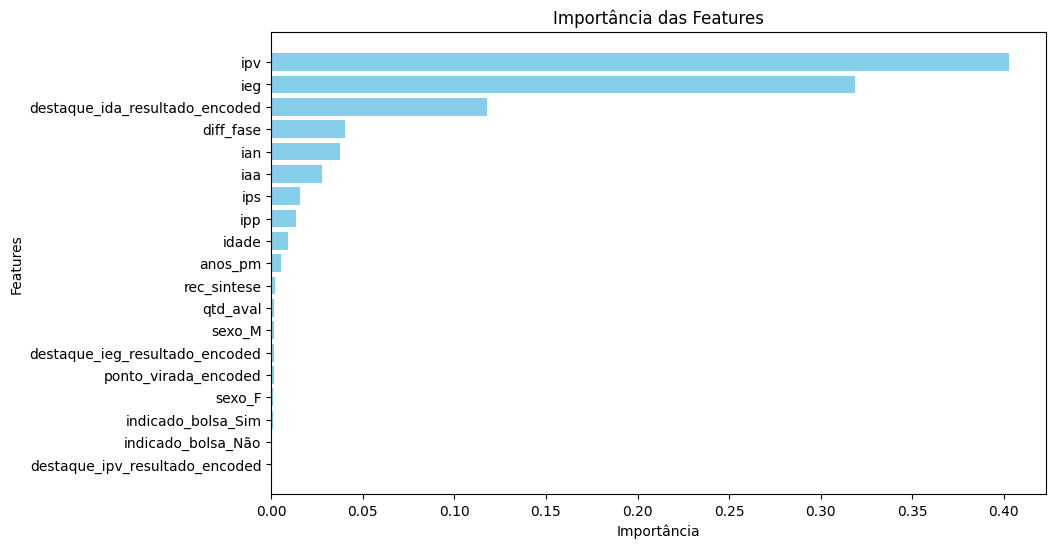

In [21]:
df_to_evaluate = df.drop(columns=["nome", "cg", "inde", "pedra", "ida"])

evaluate_features_importance(
    df_to_evaluate,
    "cg_normalized_inverted",
    ["sexo", "indicado_bolsa"],
)


R²: 0.9685270833857983
MAE: 0.04148630776150867
                           Feature  Importance
4                              ida    0.519559
23                     pedra_Ágata    0.145818
22                   pedra_Topázio    0.101718
20                  pedra_Ametista    0.087259
21                   pedra_Quartzo    0.061228
5                              ipv    0.026012
2                              ieg    0.020769
1                              iaa    0.008142
15                       diff_fase    0.005490
6                              ian    0.005278
7                              ipp    0.004515
3                              ips    0.004456
0                            idade    0.002705
10                         anos_pm    0.001587
12  destaque_ida_resultado_encoded    0.001209
9             ponto_virada_encoded    0.001114
8                         qtd_aval    0.000572
17                          sexo_M    0.000438
11  destaque_ieg_resultado_encoded    0.000435
16          

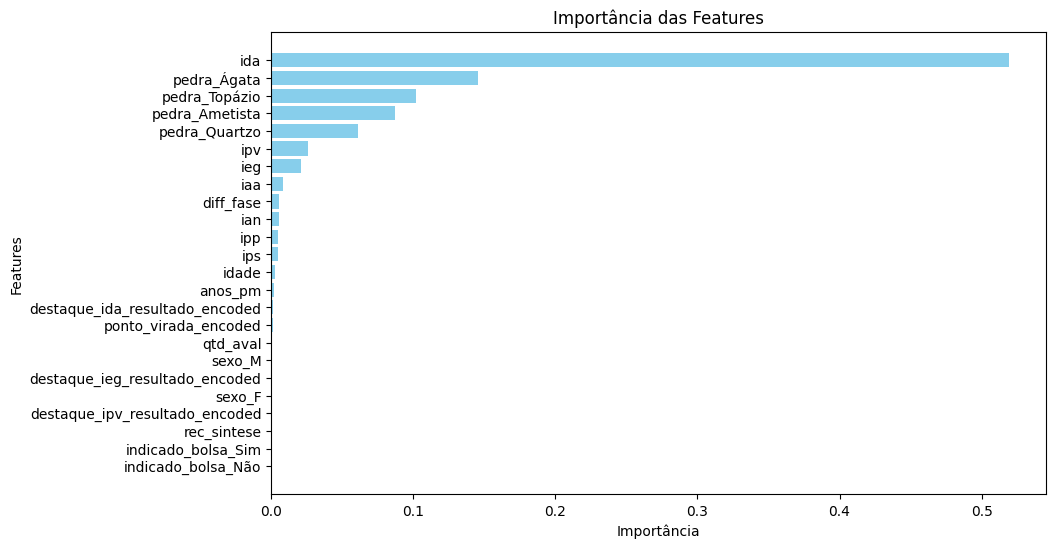

In [22]:
df_to_evaluate = df.drop(columns=["nome", "cg", "inde"])
evaluate_features_importance(
    df_to_evaluate, "cg_normalized_inverted", ["sexo", "indicado_bolsa", "pedra"]
)


In [23]:
df_to_evaluate.columns


Index(['idade', 'pedra', 'iaa', 'ieg', 'ips', 'ida', 'ipv', 'ian', 'ipp',
       'qtd_aval', 'indicado_bolsa', 'sexo', 'ponto_virada_encoded', 'anos_pm',
       'destaque_ieg_resultado_encoded', 'destaque_ida_resultado_encoded',
       'destaque_ipv_resultado_encoded', 'rec_sintese', 'diff_fase',
       'cg_normalized_inverted'],
      dtype='object')

In [24]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import LabelEncoder, StandardScaler

df_to_evaluate = df.drop(columns=["nome", "cg", "inde"])


# Pré-processamento de variáveis categóricas
# Codificar a variável 'Genero'
le = LabelEncoder()
df_to_evaluate["sexo_Encoded"] = le.fit_transform(df["sexo"])
df_to_evaluate["bolsa_Encoded"] = le.fit_transform(df["indicado_bolsa"])

# Aplicar One-Hot Encoding na variável 'Curso'
df_pedra_encoded = pd.get_dummies(df["pedra"], prefix="predra")

# Concatenar as variáveis codificadas ao DataFrame original
df_to_evaluate = pd.concat([df_to_evaluate, df_pedra_encoded], axis=1)

# Visualizar o DataFrame atualizado
print("DataFrame com variáveis categóricas codificadas:")
print(df_to_evaluate.head())


DataFrame com variáveis categóricas codificadas:
   idade     pedra       iaa       ieg  ips       ida       ipv   ian  \
0   11.0  Ametista  10.00002  7.581705  7.5  8.816667  7.916665   5.0   
1   12.0  Ametista  10.00002  8.071429  7.5  5.083333  8.055553   5.0   
2   12.0  Ametista   6.41668  8.557505  7.5  7.083333  7.833337   5.0   
3   11.0  Ametista   9.00002  9.333333  7.5  5.500000  7.500000  10.0   
4   11.0  Ametista  10.00002  9.314954  7.5  5.583333  7.916670   5.0   

        ipp  qtd_aval  ... destaque_ipv_resultado_encoded rec_sintese  \
0  5.625000       2.0  ...                              1         1.0   
1  6.250000       3.0  ...                              1         1.0   
2  6.458333       3.0  ...                              1         0.0   
3  6.250000       3.0  ...                              1         0.0   
4  5.937500       2.0  ...                              1         1.0   

   diff_fase  cg_normalized_inverted  sexo_Encoded  bolsa_Encoded  \
0   

In [25]:
df_to_evaluate.columns


Index(['idade', 'pedra', 'iaa', 'ieg', 'ips', 'ida', 'ipv', 'ian', 'ipp',
       'qtd_aval', 'indicado_bolsa', 'sexo', 'ponto_virada_encoded', 'anos_pm',
       'destaque_ieg_resultado_encoded', 'destaque_ida_resultado_encoded',
       'destaque_ipv_resultado_encoded', 'rec_sintese', 'diff_fase',
       'cg_normalized_inverted', 'sexo_Encoded', 'bolsa_Encoded',
       'predra_Ametista', 'predra_Quartzo', 'predra_Topázio', 'predra_Ágata'],
      dtype='object')

In [26]:
# Variáveis para normalização
variaveis_para_normalizar = [
    "idade",
    "iaa",
    "ieg",
    "ips",
    "ida",
    "ipv",
    "ian",
    "ipp",
    "qtd_aval",
    "ponto_virada_encoded",
    "anos_pm",
    "destaque_ieg_resultado_encoded",
    "destaque_ida_resultado_encoded",
    "destaque_ipv_resultado_encoded",
    "rec_sintese",
    "diff_fase",
    "sexo_Encoded",
    "bolsa_Encoded",
    "predra_Ametista",
    "predra_Quartzo",
    "predra_Topázio",
    "predra_Ágata",
]

# Aplicar a padronização
scaler = StandardScaler()
dados_normalizados = scaler.fit_transform(df_to_evaluate[variaveis_para_normalizar])
df_normalizado = pd.DataFrame(dados_normalizados, columns=variaveis_para_normalizar)

# Visualizar os dados normalizados
print("\nDados normalizados:")
print(df_normalizado.head())

# Lista de variáveis independentes atualizada
variaveis_independentes = variaveis_para_normalizar

# Calcular as correlações
correlacoes = []
for var in variaveis_independentes:
    corr = df_to_evaluate["cg_normalized_inverted"].corr(df_normalizado[var])
    correlacoes.append(corr)

# Criar um DataFrame com as correlações
df_correlacoes = pd.DataFrame(
    {"Variavel": variaveis_independentes, "Correlacao": correlacoes}
)

print("\nCorrelações entre as variáveis independentes e o desempenho acadêmico:")
print(df_correlacoes)



Dados normalizados:
      idade       iaa       ieg       ips       ida       ipv       ian  \
0 -0.498767  0.835453 -0.181438  0.559937  1.334197  0.609077 -0.595497   
1 -0.123604  0.835453  0.115712  0.559937 -0.479729  0.735580 -0.595497   
2 -0.123604 -0.888088  0.410649  0.559937  0.492017  0.533180 -0.595497   
3 -0.498767  0.354466  0.881400  0.559937 -0.277282  0.229570  1.499681   
4 -0.498767  0.835453  0.870248  0.559937 -0.236793  0.609082 -0.595497   

        ipp  qtd_aval  ponto_virada_encoded  ...  \
0 -0.594232 -1.363044             -0.388417  ...   
1 -0.043499 -0.073314             -0.388417  ...   
2  0.140079 -0.073314             -0.388417  ...   
3 -0.043499 -0.073314             -0.388417  ...   
4 -0.318865 -1.363044             -0.388417  ...   

   destaque_ida_resultado_encoded  destaque_ipv_resultado_encoded  \
0                        1.614526                        1.134228   
1                       -0.619377                        1.134228   
2       

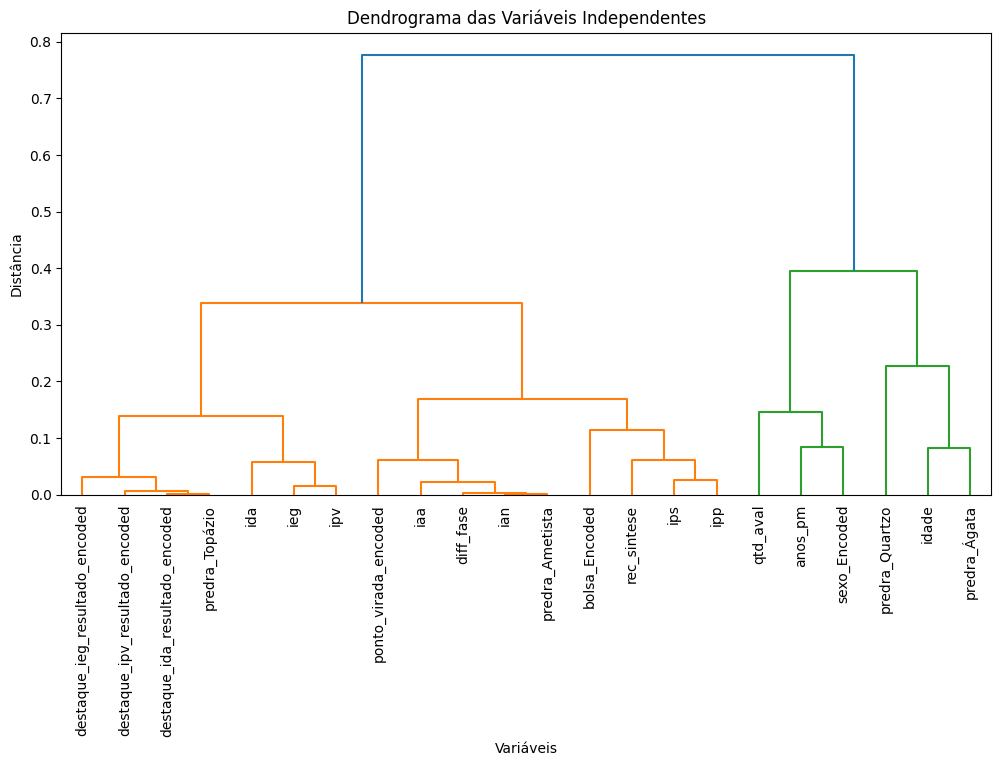

In [38]:
# Converter as correlações em um array numpy
correlacoes_array = np.array(correlacoes)

# Calcular a matriz de distância usando a diferença absoluta
distancias = pdist(correlacoes_array.reshape(-1, 1), metric="cityblock")

# Realizar a clusterização hierárquica
Z = linkage(distancias, method="average")

# Plotar o dendrograma
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=variaveis_independentes, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma das Variáveis Independentes")
plt.xlabel("Variáveis")
plt.ylabel("Distância")
plt.show()


In [40]:
import plotly.figure_factory as ff

# Converter as correlações em um array numpy
correlacoes_array = np.array(correlacoes)

# Calcular a matriz de distância usando a diferença absoluta
distancias = pdist(correlacoes_array.reshape(-1, 1), metric="cityblock")

# Realizar a clusterização hierárquica
Z = linkage(distancias, method="average")

# Criar o dendrograma usando Plotly
fig = ff.create_dendrogram(
    correlacoes_array.reshape(-1, 1),
    orientation="bottom",
    labels=variaveis_independentes,
    linkagefun=lambda x: linkage(x, method="average", metric="cityblock"),
)

# Ajustar o layout para evitar sobreposição das legendas
fig.update_layout(
    width=1200,
    height=600,
    title="Dendrograma das Variáveis Independentes",
    xaxis_title="Variáveis",
    yaxis_title="Distância",
    xaxis=dict(tickangle=-90, tickfont=dict(size=10), automargin=True),
    margin=dict(b=200),
)

# Exibir o dendrograma
fig.show()


# Clusterização GMM e PCA

Melhor número de clusters: 4
Melhor tipo de covariância: full


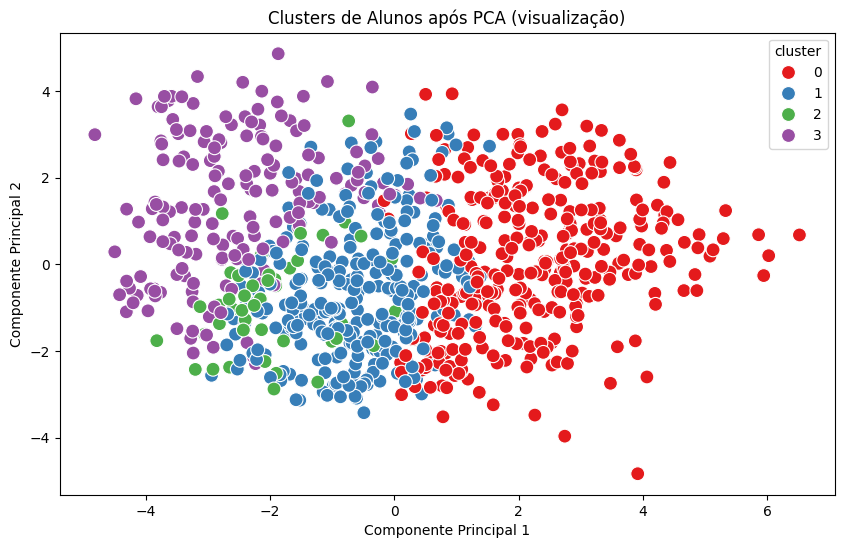

        idade       iaa       ieg       ips     ida       ipv       ian  \
PC1  0.200264 -0.171007 -0.357065 -0.116646 -0.3722 -0.386467 -0.140725   
PC2  0.441042 -0.159593 -0.047108 -0.040099  0.0156  0.119436 -0.048566   

          ipp  qtd_aval  ponto_virada_encoded  ...  rec_sintese  diff_fase  \
PC1 -0.083818  0.142049             -0.248353  ...    -0.166615  -0.164348   
PC2  0.474862  0.471616              0.192790  ...     0.347239  -0.042007   

       sexo_F    sexo_M  indicado_bolsa_Não  indicado_bolsa_Sim  \
PC1 -0.002872  0.002872            0.028716           -0.028716   
PC2 -0.004716  0.004716           -0.074002            0.074002   

     pedra_Ametista  pedra_Quartzo  pedra_Topázio  pedra_Ágata  
PC1       -0.088214       0.110929      -0.093287     0.070573  
PC2       -0.031542       0.011647       0.030931    -0.011036  

[2 rows x 24 columns]


In [228]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Definir as variáveis independentes (excluir colunas irrelevantes como 'nome', 'cg', 'cg_normalized_inverted', 'inde', 'pedra')
X = df.drop(columns=["nome", "cg", "inde", "cg_normalized_inverted"])

# Definir as variáveis categóricas e numéricas
categorical_features = ["sexo", "indicado_bolsa", "pedra"]
numerical_features = X.drop(columns=categorical_features).columns.tolist()

# Pipeline de pré-processamento
numerical_transformer = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(strategy="mean"),
        ),  # Preencher valores numéricos ausentes
        ("scaler", StandardScaler()),  # Normalizar os dados numéricos
    ]
)

categorical_transformer = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(strategy="most_frequent"),
        ),  # Preencher categóricos com o valor mais frequente
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore"),
        ),  # OneHotEncode para variáveis categóricas
    ]
)

# Aplicar as transformações nas variáveis categóricas e numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Pipeline sem PCA para o GMM
gmm_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("gmm", GaussianMixture())]
)

# Definir hiperparâmetros para o GridSearch
param_grid = {
    "gmm__n_components": range(2, 10),  # Tentamos diferentes números de clusters
    "gmm__covariance_type": [
        "full",
        "tied",
        "diag",
        "spherical",
    ],  # Diferentes tipos de covariância
}

# Aplicar GridSearchCV para encontrar os melhores hiperparâmetros, sem scoring supervisionado
grid_search = GridSearchCV(gmm_pipeline, param_grid, cv=3)
grid_search.fit(X)

# Melhor número de clusters e covariância
best_gmm = grid_search.best_estimator_
print(f'Melhor número de clusters: {grid_search.best_params_["gmm__n_components"]}')
print(f'Melhor tipo de covariância: {grid_search.best_params_["gmm__covariance_type"]}')

# Prever os clusters nos dados originais
preprocessed_X = best_gmm.named_steps["preprocessor"].transform(X)
clusters = best_gmm.named_steps["gmm"].predict(preprocessed_X)

# Aplicar PCA apenas para visualização (reduzir para 2 componentes)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(preprocessed_X)

# Adicionar os clusters e os componentes principais no DataFrame
df["cluster"] = clusters
df["pca_1"] = X_pca[:, 0]
df["pca_2"] = X_pca[:, 1]

# Visualizar os clusters nos componentes principais
plt.figure(figsize=(10, 6))
sns.scatterplot(x="pca_1", y="pca_2", hue="cluster", data=df, palette="Set1", s=100)
plt.title("Clusters de Alunos após PCA (visualização)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

# Analisar os componentes do PCA para interpretação
pca_components = pd.DataFrame(
    pca.components_,
    columns=numerical_features
    + list(
        best_gmm.named_steps["preprocessor"]
        .transformers_[1][1]
        .named_steps["onehot"]
        .get_feature_names_out(categorical_features)
    ),
    index=["PC1", "PC2"],
)
print(pca_components)


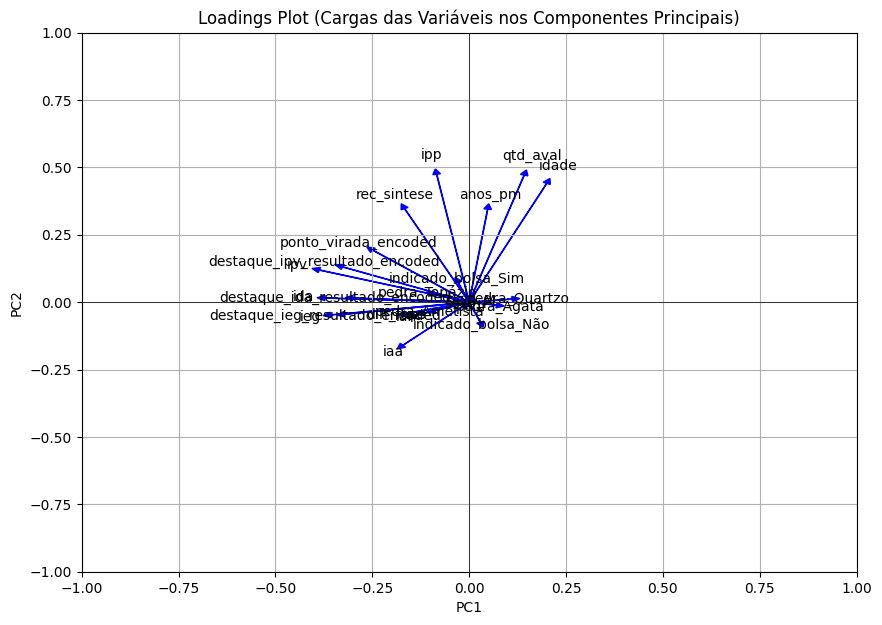

In [229]:
import matplotlib.pyplot as plt
import numpy as np

# Extrair os coeficientes (cargas) dos componentes principais
pca_components = pd.DataFrame(
    pca.components_,
    columns=numerical_features
    + list(
        best_gmm.named_steps["preprocessor"]
        .transformers_[1][1]
        .named_steps["onehot"]
        .get_feature_names_out(categorical_features)
    ),
    index=["PC1", "PC2"],
)

# Plotar as cargas das variáveis nos dois primeiros componentes
plt.figure(figsize=(10, 7))
for i, var in enumerate(pca_components.columns):
    plt.arrow(
        0,
        0,
        pca_components.iloc[0, i],
        pca_components.iloc[1, i],
        head_width=0.02,
        head_length=0.02,
        color="blue",
    )
    plt.text(
        pca_components.iloc[0, i] * 1.15,
        pca_components.iloc[1, i] * 1.15,
        var,
        color="black",
        ha="center",
        va="center",
    )

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.grid()
plt.title("Loadings Plot (Cargas das Variáveis nos Componentes Principais)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


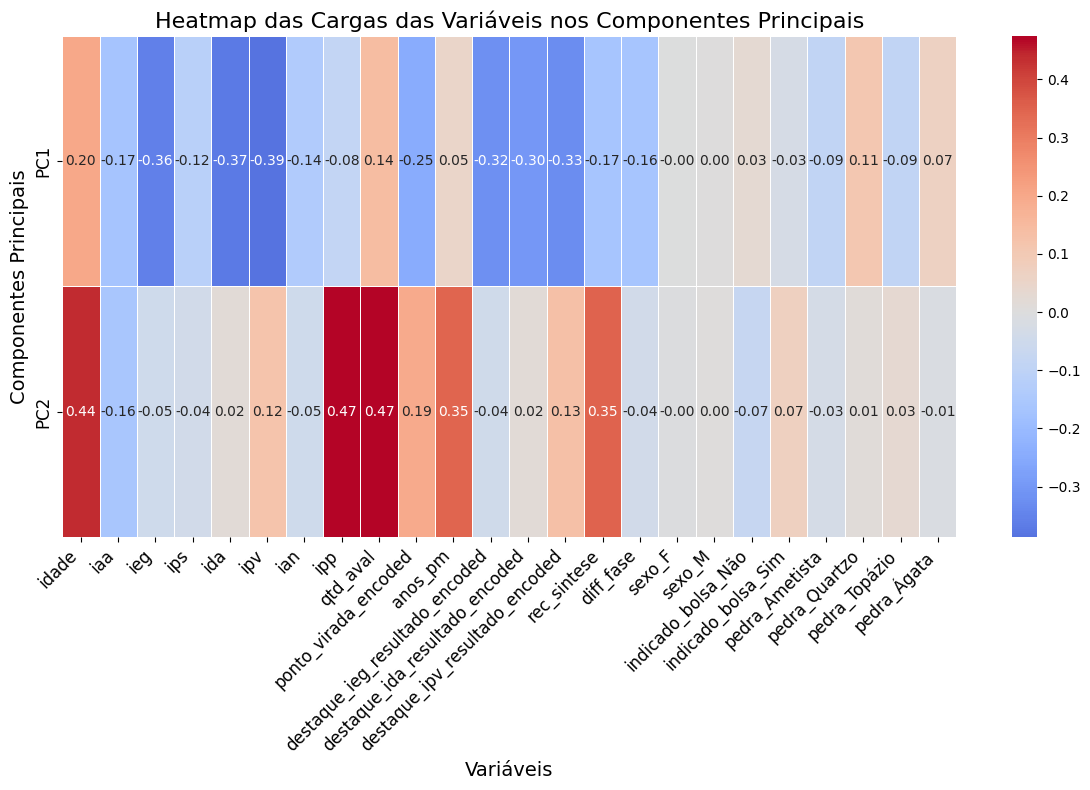

In [230]:
# Ajustar o tamanho da figura para que o heatmap seja mais legível
plt.figure(figsize=(12, 8))

# Criar o heatmap das cargas dos componentes principais
sns.heatmap(
    pca_components,
    annot=True,
    cmap="coolwarm",
    center=0,
    annot_kws={"size": 10},
    fmt=".2f",
    linewidths=0.5,
)

# Título e rótulos
plt.title("Heatmap das Cargas das Variáveis nos Componentes Principais", fontsize=16)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)
plt.xlabel("Variáveis", fontsize=14)
plt.ylabel("Componentes Principais", fontsize=14)

# Exibir o gráfico
plt.tight_layout()
plt.show()


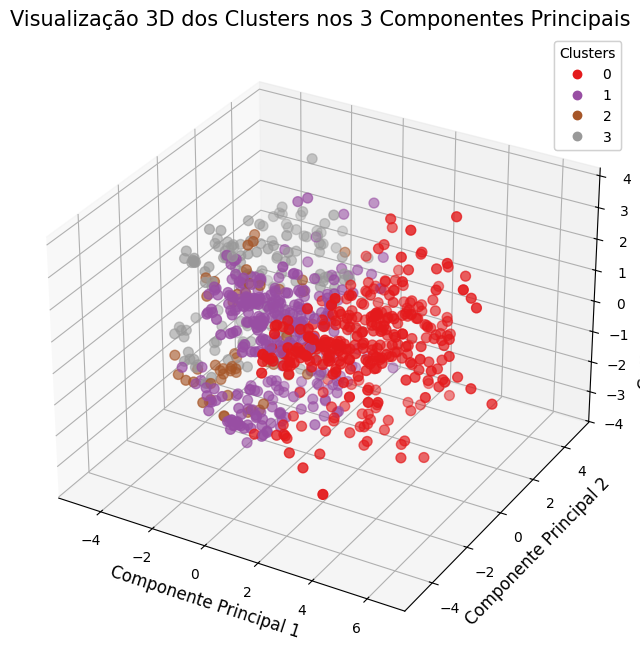

In [231]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Aplicar PCA com 3 componentes
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(preprocessed_X)

# Adicionar os três componentes principais ao DataFrame
df["pca_1"] = X_pca_3d[:, 0]
df["pca_2"] = X_pca_3d[:, 1]
df["pca_3"] = X_pca_3d[:, 2]

# Visualizar os clusters em 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot em 3D com os componentes principais
scatter = ax.scatter(
    df["pca_1"], df["pca_2"], df["pca_3"], c=df["cluster"], cmap="Set1", s=50
)

# Adicionar rótulos e título
ax.set_title("Visualização 3D dos Clusters nos 3 Componentes Principais", fontsize=15)
ax.set_xlabel("Componente Principal 1", fontsize=12)
ax.set_ylabel("Componente Principal 2", fontsize=12)
ax.set_zlabel("Componente Principal 3", fontsize=12)

# Adicionar legenda
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()


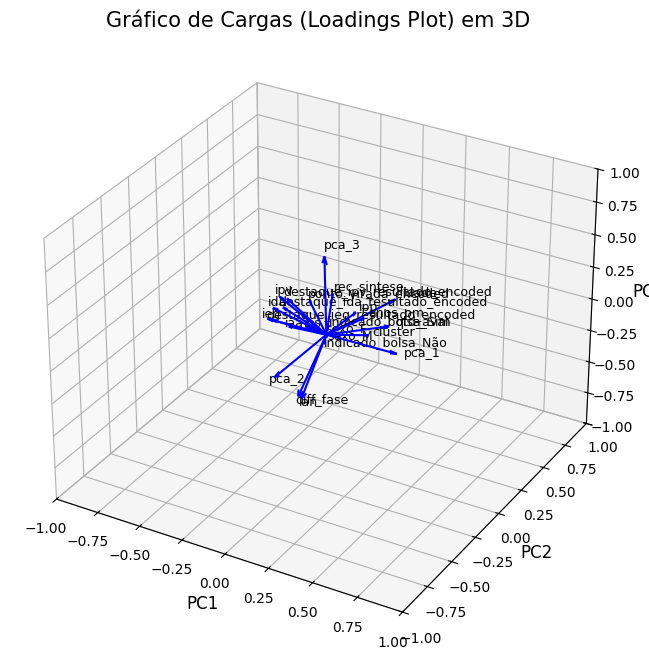

In [193]:
import numpy as np

# Extrair os coeficientes (cargas) dos três primeiros componentes principais
pca_components_3d = pd.DataFrame(
    pca_3d.components_,
    columns=numerical_features
    + list(
        best_gmm.named_steps["preprocessor"]
        .transformers_[1][1]
        .named_steps["onehot"]
        .get_feature_names_out(categorical_features)
    ),
    index=["PC1", "PC2", "PC3"],
)

# Gráfico 3D para as cargas
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Para cada variável, adicionar um vetor representando a contribuição para cada componente
for i, var in enumerate(pca_components_3d.columns):
    ax.quiver(
        0,
        0,
        0,
        pca_components_3d.iloc[0, i],
        pca_components_3d.iloc[1, i],
        pca_components_3d.iloc[2, i],
        color="blue",
        arrow_length_ratio=0.1,
    )
    ax.text(
        pca_components_3d.iloc[0, i] * 1.1,
        pca_components_3d.iloc[1, i] * 1.1,
        pca_components_3d.iloc[2, i] * 1.1,
        var,
        fontsize=9,
        color="black",
    )

# Configurações do gráfico
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel("PC1", fontsize=12)
ax.set_ylabel("PC2", fontsize=12)
ax.set_zlabel("PC3", fontsize=12)
ax.set_title("Gráfico de Cargas (Loadings Plot) em 3D", fontsize=15)

plt.show()


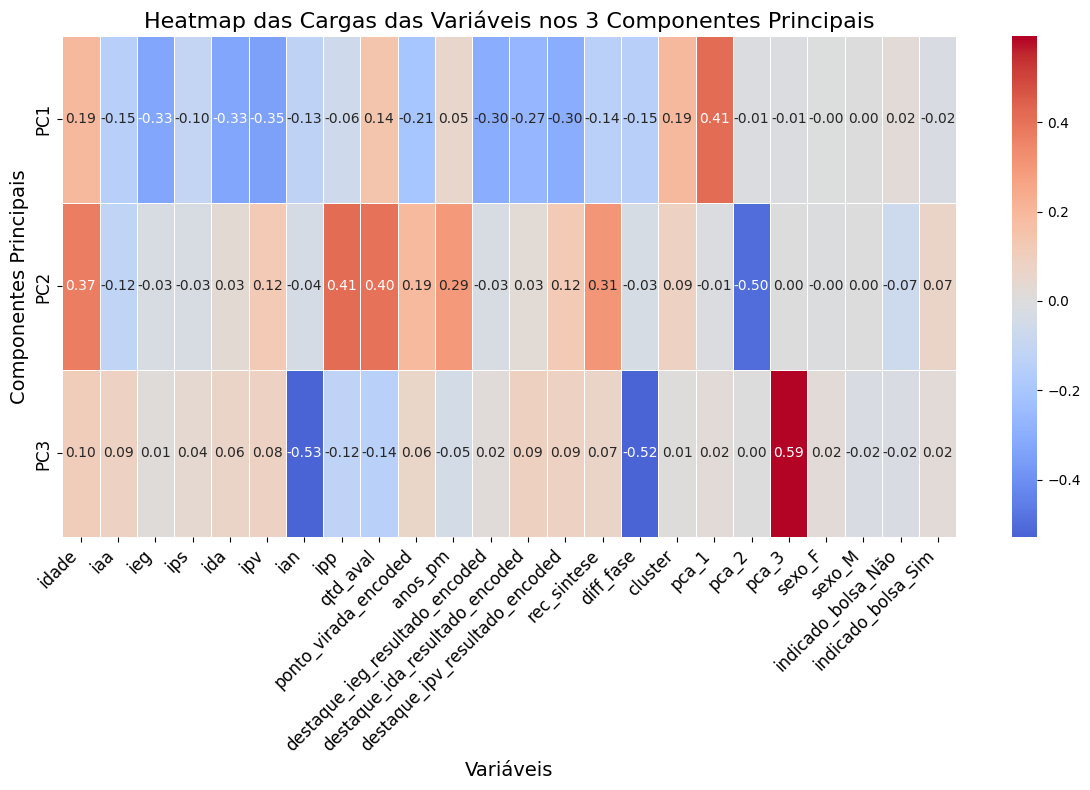

In [194]:
# Criar o heatmap das cargas com três componentes principais
plt.figure(figsize=(12, 8))
sns.heatmap(
    pca_components_3d,
    annot=True,
    cmap="coolwarm",
    center=0,
    annot_kws={"size": 10},
    fmt=".2f",
    linewidths=0.5,
)

# Título e rótulos
plt.title("Heatmap das Cargas das Variáveis nos 3 Componentes Principais", fontsize=16)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)
plt.xlabel("Variáveis", fontsize=14)
plt.ylabel("Componentes Principais", fontsize=14)

# Exibir o gráfico
plt.tight_layout()
plt.show()


In [195]:
import plotly.express as px

# Aplicar PCA com 3 componentes
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(preprocessed_X)

# Adicionar os três componentes principais ao DataFrame
df["pca_1"] = X_pca_3d[:, 0]
df["pca_2"] = X_pca_3d[:, 1]
df["pca_3"] = X_pca_3d[:, 2]

# Criar a visualização 3D interativa com Plotly
fig = px.scatter_3d(
    df,
    x="pca_1",
    y="pca_2",
    z="pca_3",
    color="cluster",
    title="Visualização 3D dos Clusters nos 3 Componentes Principais",
    labels={
        "pca_1": "Componente Principal 1",
        "pca_2": "Componente Principal 2",
        "pca_3": "Componente Principal 3",
    },
    opacity=0.7,
    size_max=18,
)

# Ajustar o tamanho da figura
fig.update_layout(
    scene=dict(
        xaxis_title="Componente Principal 1",
        yaxis_title="Componente Principal 2",
        zaxis_title="Componente Principal 3",
    ),
    width=800,
    height=700,
)

# Exibir a figura interativa
fig.show()


In [196]:
# import plotly.figure_factory as ff

# # Converter os rótulos dos eixos para listas
# x_labels = pca_components_3d.columns.tolist()  # Convertendo para lista
# y_labels = pca_components_3d.index.tolist()  # Convertendo para lista

# # Criar o heatmap interativo com Plotly
# fig = ff.create_annotated_heatmap(
#     z=z_values,
#     x=x_labels,
#     y=y_labels,
#     colorscale="RdBu",
#     annotation_text=np.round(z_values, 2),  # Limitar a 2 casas decimais nas anotações
#     showscale=True,  # Exibe a barra de cores
# )

# # Ajustar o layout para colocar os rótulos do eixo X abaixo do gráfico
# fig.update_layout(
#     title="Heatmap das Cargas das Variáveis nos 3 Componentes Principais",
#     width=1000,
#     height=600,
#     xaxis=dict(
#         tickangle=45,  # Ajustar a rotação dos rótulos para 45 graus para melhor legibilidade
#         side="bottom",  # Posicionar os rótulos na parte inferior
#         tickmode="array",  # Garante que todos os rótulos apareçam
#     ),
# )

# # Exibir o heatmap
# fig.show()


In [197]:
import plotly.graph_objects as go

# Criar uma figura 3D para o gráfico de cargas
fig = go.Figure()

# Adicionar os vetores (flechas) para cada variável nos três componentes principais
for i, var in enumerate(pca_components_3d.columns):
    # Vetor do ponto (0, 0, 0) até (PC1, PC2, PC3)
    fig.add_trace(
        go.Scatter3d(
            x=[0, pca_components_3d.iloc[0, i]],  # Componente PC1
            y=[0, pca_components_3d.iloc[1, i]],  # Componente PC2
            z=[0, pca_components_3d.iloc[2, i]],  # Componente PC3
            mode="lines",  # Apenas a linha para o vetor
            line=dict(width=4, color="blue"),  # Estilo da linha do vetor
            showlegend=False,  # Desabilitar a legenda
        )
    )

    # Adicionar um marcador maior no final do vetor (para simular uma seta)
    fig.add_trace(
        go.Scatter3d(
            x=[pca_components_3d.iloc[0, i]],  # Componente PC1
            y=[pca_components_3d.iloc[1, i]],  # Componente PC2
            z=[pca_components_3d.iloc[2, i]],  # Componente PC3
            mode="markers+text",  # Marcador e texto
            marker=dict(
                size=5, color="red"
            ),  # Marcador no final do vetor (simula uma seta)
            text=[var],  # Nome da variável
            textposition="top right",  # Posição do texto
            showlegend=False,  # Desabilitar a legenda
        )
    )

# Ajustar o layout da visualização
fig.update_layout(
    title="Gráfico de Cargas (Loadings Plot) em 3D",
    scene=dict(
        xaxis_title="PC1 (Componente Principal 1)",
        yaxis_title="PC2 (Componente Principal 2)",
        zaxis_title="PC3 (Componente Principal 3)",
        xaxis=dict(range=[-1, 1]),
        yaxis=dict(range=[-1, 1]),
        zaxis=dict(range=[-1, 1]),
    ),
    width=800,
    height=700,
)

# Exibir o gráfico interativo
fig.show()


# Análise para verificar se a diferença entre os clusters é estatisticamente significativa

In [198]:
X.columns.to_list()


['idade',
 'iaa',
 'ieg',
 'ips',
 'ida',
 'ipv',
 'ian',
 'ipp',
 'qtd_aval',
 'indicado_bolsa',
 'sexo',
 'ponto_virada_encoded',
 'anos_pm',
 'destaque_ieg_resultado_encoded',
 'destaque_ida_resultado_encoded',
 'destaque_ipv_resultado_encoded',
 'rec_sintese',
 'diff_fase',
 'cluster',
 'pca_1',
 'pca_2',
 'pca_3']

In [199]:
from scipy.stats import shapiro, levene, f_oneway, kruskal


# Função para testar a normalidade em cada cluster
def test_normality(data, clusters):
    normality_results = {}
    for cluster in np.unique(clusters):
        cluster_data = data[clusters == cluster]
        stat, p_value = shapiro(cluster_data)
        normality_results[cluster] = p_value
    return normality_results


# Testar a normalidade para uma variável de interesse (ex: 'iaa')
normality_results = test_normality(df["cg_normalized_inverted"], df["cluster"])
print(f"P-valores do teste de Shapiro-Wilk para normalidade por cluster - ({v}):")
print(normality_results)


P-valores do teste de Shapiro-Wilk para normalidade por cluster - (cg_normalized_inverted):
{0: 1.2271669584738829e-05, 1: 1.89448947656139e-05, 2: 4.716760903627988e-09, 3: 8.882367851538322e-06, 4: 3.318487125248883e-08}


- Se os p-valores forem maiores que 0.05, podemos assumir que a normalidade não foi violada para o respectivo cluster.
- Se os p-valores forem menores que 0.05, significa que a normalidade foi violada para aquele cluster, e devemos considerar usar uma abordagem não paramétrica.

In [200]:
# Testar a homogeneidade de variâncias entre os clusters
stat, p_value = levene(
    df["cg_normalized_inverted"][df["cluster"] == 0],
    df["cg_normalized_inverted"][df["cluster"] == 1],
    df["cg_normalized_inverted"][df["cluster"] == 2],
    df["cg_normalized_inverted"][df["cluster"] == 3],
    df["cg_normalized_inverted"][df["cluster"] == 4],
    df["cg_normalized_inverted"][df["cluster"] == 5],
    df["cg_normalized_inverted"][df["cluster"] == 6],
)


print(f"P-valor do teste de Levene para homogeneidade de variâncias: {p_value}")


P-valor do teste de Levene para homogeneidade de variâncias: nan


/home/alien-wsl/projects/datathon_app/datathonapp/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/home/alien-wsl/projects/datathon_app/datathonapp/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



- Se o p-valor for maior que 0.05, podemos assumir que as variâncias são homogêneas, atendendo ao pressuposto da ANOVA.
- Se o p-valor for menor que 0.05, as variâncias são significativamente diferentes entre os clusters.

In [201]:
# Realizar Kruskal-Wallis entre os clusters para a variável 'iaa'
kruskal_result = kruskal(
    df["cg_normalized_inverted"][df["cluster"] == 0],
    df["cg_normalized_inverted"][df["cluster"] == 1],
    df["cg_normalized_inverted"][df["cluster"] == 2],
    df["cg_normalized_inverted"][df["cluster"] == 3],
    df["cg_normalized_inverted"][df["cluster"] == 4],
    df["cg_normalized_inverted"][df["cluster"] == 5],
    df["cg_normalized_inverted"][df["cluster"] == 6],
)

print(
    f"Resultado do Kruskal-Wallis: Estatística H = {kruskal_result.statistic}, P-valor = {kruskal_result.pvalue}"
)


Resultado do Kruskal-Wallis: Estatística H = nan, P-valor = nan


- Se o p-valor for menor que 0.05, significa que há uma diferença estatisticamente significativa entre os clusters para a variável analisada.

#### Testes Estatísticos consolidados 

In [202]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene, f_oneway, kruskal
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Reaplicando o pipeline de pré-processamento
def preprocess_data(df, vars_to_test):
    # Definir as variáveis categóricas e numéricas
    categorical_features = ["sexo", "indicado_bolsa"]
    numerical_features = [
        var for var in vars_to_test if var not in categorical_features
    ]

    # Pipeline de pré-processamento
    numerical_transformer = Pipeline(
        steps=[("scaler", StandardScaler())]  # Normalizar os dados numéricos
    )

    categorical_transformer = Pipeline(
        steps=[
            (
                "onehot",
                OneHotEncoder(handle_unknown="ignore"),
            )  # OneHotEncode para variáveis categóricas
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    # Aplicar o pré-processamento nos dados originais
    preprocessed_data = preprocessor.fit_transform(df)

    return preprocessed_data


# Função para verificar normalidade, homogeneidade e realizar ANOVA ou Kruskal-Wallis com os dados pré-processados
def run_statistical_tests(df, preprocessed_data, vars_to_test):
    results = []
    num_clusters = df[
        "cluster"
    ].nunique()  # Determinar o número de clusters automaticamente

    # Loop por todas as variáveis de interesse
    for i, var in enumerate(vars_to_test):
        # Extrair os dados da variável pré-processada para cada cluster
        cluster_data = [
            preprocessed_data[df["cluster"] == cluster, i]
            for cluster in range(num_clusters)
        ]

        # Verificar se algum cluster tem variância zero
        var_zero_variance = any(np.var(cluster) == 0 for cluster in cluster_data)

        # Inicializar valores padrão
        normality_pass = "Não aplicável" if var_zero_variance else "Não testado"
        homogeneity_pass = "Não testado"
        test_type = "Não aplicável"
        test_stat = "Não aplicável"
        p_value = "Não aplicável"
        test_pass = "Não aplicável"

        # Teste de normalidade (Shapiro-Wilk), executado apenas se não houver variância zero
        if not var_zero_variance:
            normality_pvalues = [shapiro(cluster)[1] for cluster in cluster_data]
            normality_pass = all(
                p > 0.05 for p in normality_pvalues
            )  # Verificar se todos os clusters passam o teste de normalidade
            normality_pass = (
                "Normalidade atingida" if normality_pass else "Normalidade não atingida"
            )

        # Teste de homogeneidade de variâncias (Levene), sempre que houver mais de um valor diferente
        levene_stat, levene_pvalue = levene(*cluster_data)
        homogeneity_pass = (
            "Homogeneidade atingida"
            if levene_pvalue > 0.05
            else "Homogeneidade não atingida"
        )

        # Decisão de qual teste usar (ANOVA ou Kruskal-Wallis)
        if (
            normality_pass == "Normalidade atingida"
            and homogeneity_pass == "Homogeneidade atingida"
        ):
            # ANOVA
            anova_stat, anova_pvalue = f_oneway(*cluster_data)
            test_type = "ANOVA"
            test_stat = anova_stat
            p_value = anova_pvalue
            test_pass = (
                "Não há diferença significativa"
                if p_value > 0.05
                else "Há diferença significativa"
            )
        else:
            # Kruskal-Wallis (alternativa não paramétrica)
            kruskal_stat, kruskal_pvalue = kruskal(*cluster_data)
            test_type = "Kruskal-Wallis"
            test_stat = kruskal_stat
            p_value = kruskal_pvalue
            test_pass = (
                "Não há diferença significativa"
                if p_value > 0.05
                else "Há diferença significativa"
            )

        # Armazenar os resultados para esta variável
        results.append(
            {
                "Variável": var,
                "Normalidade (Shapiro-Wilk)": normality_pass,
                "Homogeneidade (Levene)": homogeneity_pass,
                "Teste Usado": test_type,
                "Estatística": test_stat,
                "P-Valor": p_value,
                "Resultado Final (H0)": test_pass,  # Se H0 foi aceita ou rejeitada
            }
        )

    # Transformar os resultados em um DataFrame para facilitar a visualização
    results_df = pd.DataFrame(results)
    return results_df


# Lista de variáveis de interesse para testar
vars_to_test = X.columns.to_list()
# vars_to_test.append("cg_normalized_inverted")

# Pré-processar os dados
preprocessed_data = preprocess_data(df, vars_to_test)

# Executar os testes com os dados pré-processados
results_df = run_statistical_tests(df, preprocessed_data, vars_to_test)


# print(results_df)# Função para aplicar coloração verde/vermelha ao DataFrame
def highlight_significance(val):
    if isinstance(val, str):
        if "atingida" in val or "Não há diferença significativa" in val:
            color = "background-color: lightcoral"  # Verde para "atingida" ou "não há diferença"
        elif "não atingida" in val or "Há diferença significativa" in val:
            color = "background-color: green"  # Vermelho para "não atingida" ou "há diferença"
        else:
            color = ""  # Não aplica cor para outros valores
        return color


# Aplicar a coloração ao DataFrame
styled_results_df = results_df.style.map(highlight_significance)
styled_results_df  # Exibir o DataFrame estilizado


/tmp/ipykernel_34237/4203022894.py:72: UserWarning:

scipy.stats.shapiro: Input data has range zero. The results may not be accurate.

/home/alien-wsl/projects/datathon_app/datathonapp/.venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:3310: RuntimeWarning:

invalid value encountered in scalar divide



,Variável,Normalidade (Shapiro-Wilk),Homogeneidade (Levene),Teste Usado,Estatística,P-Valor,Resultado Final (H0)
0,idade,Normalidade não atingida,Homogeneidade não atingida,Kruskal-Wallis,244.798166,0.000000,Há diferença significativa
1,iaa,Normalidade não atingida,Homogeneidade não atingida,Kruskal-Wallis,85.858899,0.000000,Há diferença significativa
2,ieg,Normalidade não atingida,Homogeneidade não atingida,Kruskal-Wallis,174.821556,0.000000,Há diferença significativa
3,ips,Normalidade não atingida,Homogeneidade não atingida,Kruskal-Wallis,14.040467,0.007167,Há diferença significativa
4,ida,Normalidade não atingida,Homogeneidade não atingida,Kruskal-Wallis,218.625538,0.000000,Há diferença significativa
5,ipv,Normalidade não atingida,Homogeneidade não atingida,Kruskal-Wallis,343.991734,0.000000,Há diferença significativa
6,ian,Não aplicável,Homogeneidade não atingida,Kruskal-Wallis,553.800898,0.000000,Há diferença significativa
7,ipp,Normalidade não atingida,Homogeneidade não atingida,Kruskal-Wallis,214.241783,0.000000,Há diferença significativa
8,qtd_aval,Normalidade não atingida,Homogeneidade não atingida,Kruskal-Wallis,244.926100,0.000000,Há diferença significativa
9,indicado_bolsa,Normalidade não atingida,Homogeneidade não atingida,Kruskal-Wallis,540.978259,0.000000,Há diferença significativa


In [205]:
df.sort_values(by="cg", ascending=True).head()


,nome,idade,cg,pedra,inde,iaa,ieg,ips,ida,ipv,...,destaque_ieg_resultado_encoded,destaque_ida_resultado_encoded,destaque_ipv_resultado_encoded,rec_sintese,diff_fase,cg_normalized_inverted,cluster,pca_1,pca_2,pca_3
50,ALUNO-75,13.0,1.0,Topázio,9.441522,10.00002,9.660714,9.375,8.500000,9.750010,...,1,1,1,1.0,2.0,1.000000,0,-4.974656,3.752995,-3.332892
583,ALUNO-916,15.0,2.0,Topázio,9.354308,8.75001,10.000000,9.375,8.511111,9.666675,...,1,1,1,1.0,0.0,0.998839,0,-4.213474,4.667028,-1.441041
104,ALUNO-153,15.0,3.0,Topázio,9.105281,10.00002,9.097222,8.125,8.700000,9.291673,...,1,1,1,1.0,0.0,0.997677,0,-3.802306,4.433705,-1.509214
852,ALUNO-1334,9.0,4.0,Topázio,8.970837,9.50002,10.000000,7.500,9.333333,9.000007,...,1,1,1,1.0,0.0,0.996516,1,-4.689154,0.611581,-0.977357
594,ALUNO-930,17.0,5.0,Topázio,8.965348,10.00002,9.641304,9.375,8.466667,10.000010,...,1,1,1,1.0,-1.0,0.995354,0,-3.711836,4.720030,1.468016


<Axes: xlabel='cluster', ylabel='cg'>

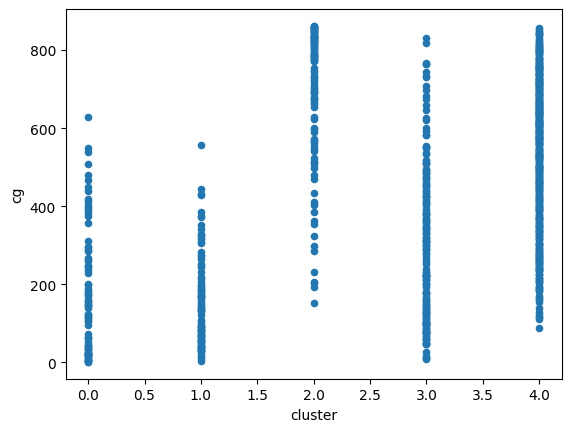

In [203]:
df.sort_values(by="cg").plot(x="cluster", y="cg", kind="scatter")


In [210]:
# only numerical features
df_mean = df.select_dtypes(include=np.number).drop(
    columns=["cg", "pca_1", "pca_2", "pca_3"]
)


df_mean.groupby("cluster").mean()


,idade,inde,iaa,ieg,ips,ida,ipv,ian,ipp,qtd_aval,ponto_virada_encoded,anos_pm,destaque_ieg_resultado_encoded,destaque_ida_resultado_encoded,destaque_ipv_resultado_encoded,rec_sintese,diff_fase,cg_normalized_inverted
cluster,,,,,,,,,,,,,,,,,,
0,14.807229,7.995071,8.107439,8.870530,7.168675,7.423025,8.416669,7.228916,8.025226,3.939759,0.554217,2.843373,1.000000,0.132530,0.807229,1.000000,-0.566265,0.787149
1,10.931818,7.997261,9.068200,8.942224,7.223011,8.101894,8.577655,6.193182,6.244673,2.590909,0.761364,1.056818,0.840909,0.454545,1.000000,0.829545,-0.943182,0.813668
2,14.771429,5.817656,5.480164,6.146122,6.779762,4.423757,6.409521,5.380952,6.576885,3.685714,0.000000,1.638095,-0.466667,-1.000000,-0.752381,0.582524,-1.485714,0.212179
3,10.709497,7.499845,8.754671,8.169801,6.864525,6.283395,7.130196,10.000000,6.212465,2.966480,0.000000,1.178771,0.474860,-0.430168,-0.273743,0.357542,0.000000,0.639798
4,12.208845,6.726662,8.622457,7.769731,6.824324,5.687060,6.990204,5.000000,5.925855,2.855037,0.000000,1.434889,0.243243,-0.621622,-0.331695,0.336609,-1.294840,0.386391


<Axes: xlabel='cluster'>

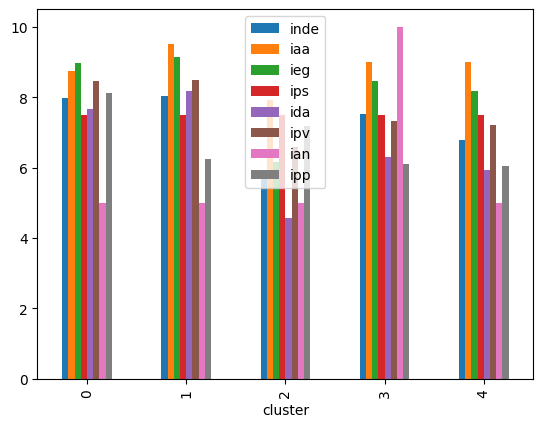

In [217]:
df_mean[["inde", "iaa", "ieg", "ips", "ida", "ipv", "ian", "ipp", "cluster"]].groupby(
    "cluster"
).median().plot(kind="bar")


Correlações entre as variáveis independentes e o desempenho acadêmico:
                 Variavel  Correlacao
0         Horas_de_Estudo    0.996757
1    Participacao_em_Aula    0.937849
2           Horas_de_Sono    0.960807
3  Ativ_Extracurriculares   -0.981285
4           Redes_Sociais   -0.981638


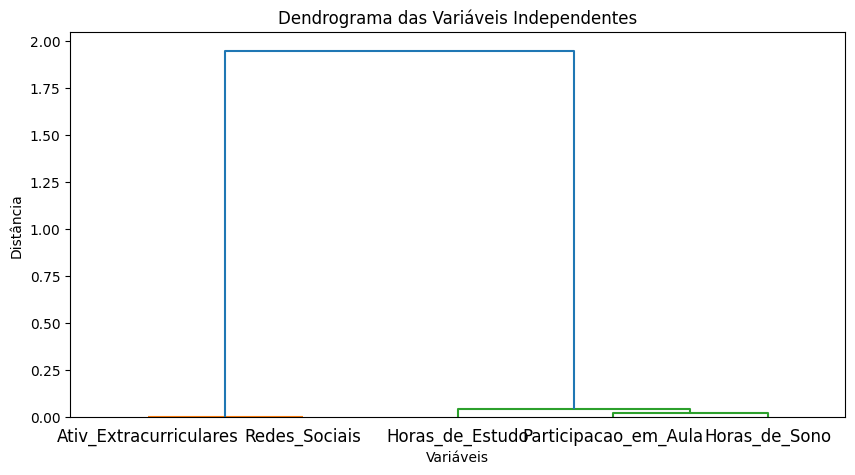

In [243]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# Dados do exemplo
data = {
    "Estudante": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "Desempenho_Academico": [85, 78, 92, 70, 88, 65, 90, 75, 95, 68],
    "Horas_de_Estudo": [15, 12, 18, 10, 16, 8, 17, 11, 19, 9],
    "Participacao_em_Aula": [10, 9, 10, 8, 9, 7, 10, 8, 10, 7],
    "Horas_de_Sono": [7, 6, 8, 6, 7, 5, 7, 6, 8, 5],
    "Ativ_Extracurriculares": [5, 6, 4, 7, 5, 8, 4, 6, 3, 7],
    "Redes_Sociais": [2, 3, 1, 4, 2, 5, 1, 3, 1, 4],
}

df = pd.DataFrame(data)

# Lista de variáveis independentes
variaveis_independentes = [
    "Horas_de_Estudo",
    "Participacao_em_Aula",
    "Horas_de_Sono",
    "Ativ_Extracurriculares",
    "Redes_Sociais",
]

# Calcular as correlações
correlacoes = []
for var in variaveis_independentes:
    corr = df["Desempenho_Academico"].corr(df[var])
    correlacoes.append(corr)

# Criar um DataFrame com as correlações
df_correlacoes = pd.DataFrame(
    {"Variavel": variaveis_independentes, "Correlacao": correlacoes}
)

print("Correlações entre as variáveis independentes e o desempenho acadêmico:")
print(df_correlacoes)

# Converter as correlações em um array numpy
correlacoes_array = np.array(correlacoes)

# Calcular a matriz de distância usando a diferença absoluta
distancias = pdist(correlacoes_array.reshape(-1, 1), metric="cityblock")

# Realizar a clusterização hierárquica
Z = linkage(distancias, method="average")

# Plotar o dendrograma
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=variaveis_independentes)
plt.title("Dendrograma das Variáveis Independentes")
plt.xlabel("Variáveis")
plt.ylabel("Distância")
plt.show()
